# Figure 2-1

Describe spectral differentiation measure with simulated data

In [1]:
from pathlib import Path

import matplotlib
import numpy as np
import pandas as pd
import scipy.signal
import seaborn as sb
from matplotlib import pyplot as plt

import analysis
import metadata
from spectral_differentiation import spectral_differentiation_whole_stimulus

In [2]:
matplotlib.rcParams.update({'font.size': 16})

In [3]:
ENTROPY = 19283591005102385916723052837195786192730157108218751289951982
RNG = np.random.default_rng(np.random.SeedSequence(ENTROPY))

In [4]:
OUTPUT_DIR = Path("figures/fig_2-1")

In [5]:
SPIKE_SAMPLE_RATE = 1000 # Hz

## Plotting functions

In [6]:
def to_timeseries(data, fs=SPIKE_SAMPLE_RATE, start=0):
    """Convert data to a time-indexed `pd.Series`.

    Arguments:
        data: Data to convert to a timeseries.

    Keyword Arguments:
        fs: Sampling frequency of the given data, in Hz.
        new_fs: Desired sampling frequency of the returned data, in Hz.
        method: Method used to fill missing values when upsampling. See `pd.Series.fillna()`.
    """
    start = pd.Timestamp(start, unit='s')
    ms = 1e3
    freq = "{0:g}ms".format(ms / fs)
    time = pd.date_range(start, periods=len(data), freq=freq)
    return pd.Series(data, index=time)

In [7]:
def resample(ts, fs=SPIKE_SAMPLE_RATE, method="sum"):
    freq = "{0:g}ms".format(1e3 / fs)
    ts = ts.resample(freq)
    summary = getattr(ts, method)
    return summary()

In [8]:
def plot(data, fs=metadata.TWOP_SAMPLE_RATE, ax=None, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(10, 2))

    if isinstance(data, np.ndarray):
        x = np.arange(len(data)) / fs
        ax = sb.lineplot(x=x, y=data, ax=ax)
    elif isinstance(data, pd.Series):
        y = data.name
        if y is None:
            data.name = y = "signal"
        data = data.reset_index().rename(columns=dict(index="time"))
        ax = sb.lineplot(data=data, x="time", y=y, ax=ax)
        ax.set_xlabel("time (s)")
        fig.autofmt_xdate()

    return fig, ax

## GCaMP6f response kernel

In [9]:
TAU_DECAY = 0.6
TAU_RISE = 0.05


def kernel_gcamp6f(
    tau_decay=TAU_DECAY, tau_rise=TAU_RISE, half_lives=10, fs=SPIKE_SAMPLE_RATE
):
    """Return an idealized GCaMP6f kernel.

    Based on the kernel used in:

        Robustness of Spike Deconvolution for Neuronal Calcium Imaging
        Marius Pachitariu, Carsen Stringer, Kenneth D. Harris
        Journal of Neuroscience 12 September 2018, 38 (37) 7976-7985
        doi.org/10.1523/JNEUROSCI.3339-17.2018
    """
    # Rise and decay time constants
    tau_decay *= fs
    tau_rise *= fs

    # Calculate number of samples
    half_life = tau_decay * np.log(2)
    n = half_lives * int(half_life)

    decay = scipy.signal.windows.exponential(n, center=0, tau=tau_decay, sym=False)
    rise = scipy.signal.windows.exponential(n, center=0, tau=tau_rise, sym=False)

    return decay - rise

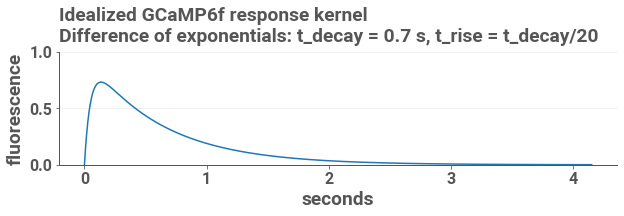

In [10]:
fs = SPIKE_SAMPLE_RATE

KERNEL = kernel_gcamp6f(fs=fs)

fig, ax = plot(KERNEL, fs=fs)
ax.set_ylim(0, 1)
ax.set_title(
    "Idealized GCaMP6f response kernel\nDifference of exponentials: t_decay = 0.7 s, t_rise = t_decay/20",
    loc="left",
    ha="left",
)
ax.set_ylabel("fluorescence")
ax.set_xlabel("seconds")
None

In [11]:
def forward_model(spikes, n=30, start=-5):
    # Convolve with calcium indicator kernel
    twop = to_timeseries(
        scipy.signal.convolve(spikes, KERNEL),
        fs=SPIKE_SAMPLE_RATE,
        start=start,
    )
    # Get middle section to avoid initial transient
    twop = twop.loc[pd.Timestamp(0, unit="s") : pd.Timestamp(n, unit="s")]
    # Downsample to 30 Hz
    twop = resample(twop, fs=metadata.TWOP_SAMPLE_RATE, method="ffill")
    return twop[: int(metadata.TWOP_SAMPLE_RATE * n)]

## Artificial spike trains

In [12]:
def burst(
    n_per_burst=10,
    rate=40,
    magnitude=1,
    fs=SPIKE_SAMPLE_RATE,
):
    # Generate the burst pattern
    isi = int(fs // rate)
    signal = np.zeros(isi * n_per_burst)
    signal[::isi] = magnitude
    return signal

In [13]:
def insert_bursts(signal, burst, starts):
    idx = starts.astype(int).reshape(-1, 1) + np.arange(len(burst)).reshape(1, -1)
    signal[idx] = burst
    return signal

In [14]:
def periodic_bursts(
    length=30,
    rate=1,
    n_per_burst=10,
    burst_rate=40,
    magnitude=1,
    offset=0,
    fs=SPIKE_SAMPLE_RATE,
):
    # Find indices of bursts
    num_bursts = int(length * rate)
    starts = (fs * offset) + np.linspace(
        0, fs * length, num=num_bursts, endpoint=False, dtype=int
    )

    signal = np.zeros(fs * length)
    return insert_bursts(
        signal,
        burst(n_per_burst=n_per_burst, rate=burst_rate, magnitude=magnitude, fs=fs),
        starts,
    )

In [15]:
def poisson_spikes(length=30, lam=0.1, fs=SPIKE_SAMPLE_RATE):
    signal = np.zeros(length * fs)
    lam *= fs
    isi = RNG.poisson(lam=lam, size=int(signal.size / lam))
    idx = np.cumsum(isi)
    signal[idx[idx < signal.size]] = 1
    return signal

In [16]:
def poisson_bursts(
    length=30,
    lam=1.0,
    n_per_burst=10,
    burst_rate=40,
    magnitude=1,
    fs=SPIKE_SAMPLE_RATE,
):
    burst_pattern = burst(
        n_per_burst=n_per_burst, rate=burst_rate, magnitude=magnitude, fs=fs
    )
    starts = poisson_spikes(length=length, lam=lam, fs=SPIKE_SAMPLE_RATE).nonzero()[0]
    signal = np.zeros(fs * length)
    starts = starts[starts < (signal.size - len(burst_pattern))]
    return insert_bursts(signal, burst_pattern, starts)

In [17]:
def plot_pattern(spikes):
    fig, axes = plt.subplots(2, 1, figsize=(10, 2 * 2.5), sharex=True)

    fig, ax = plot(spikes, fs=SPIKE_SAMPLE_RATE, ax=axes[0], fig=fig)
    ax.set_title(f"Spike train", loc="left", ha="left")
    ax.set_ylabel("count")

    twop = forward_model(spikes)
    fig, ax = plot(twop, ax=axes[1], fig=fig)
    ax.set_title("Convolution with idealized GCaMP6f kernel", loc="left", ha="left")
    ax.set_ylabel("dF/F")
    ax.set_ylim((0, twop.max() * 1.1))

    fig.subplots_adjust(hspace=0.25)

    plt.close("all")
    return fig

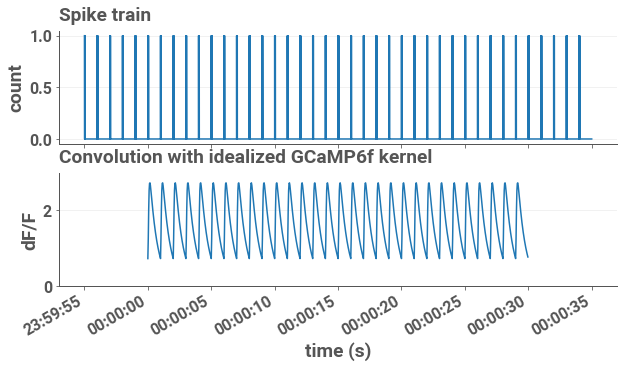

In [18]:
regular_bursts = to_timeseries(
    periodic_bursts(
        length=40, n_per_burst=3, rate=1.0, magnitude=1.0, offset=0.0, fs=SPIKE_SAMPLE_RATE
    ),
    fs=SPIKE_SAMPLE_RATE,
    start=-5,
)

plot_pattern(regular_bursts)

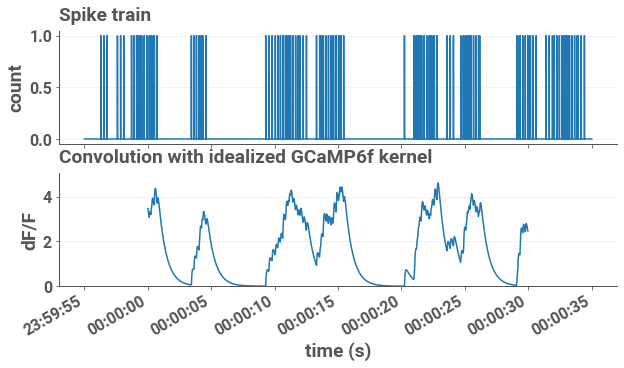

In [19]:
irregular_bursts = poisson_bursts(
    length=40,
    lam=3.7,
    n_per_burst=10,
    burst_rate=5,
    magnitude=1,
    fs=SPIKE_SAMPLE_RATE,
) + poisson_bursts(
    length=40,
    lam=1.3,
    n_per_burst=3,
    burst_rate=4,
    magnitude=1,
    fs=SPIKE_SAMPLE_RATE,
)
irregular_bursts = to_timeseries(
    irregular_bursts,
    fs=SPIKE_SAMPLE_RATE,
    start=-5,
)
silent = [(1.5, 3.4), (5.2, 8.9), (15.5, 20), (26.2, 29)]
for start, end in silent:
    irregular_bursts.loc[
        pd.Timestamp(start, unit="s") : pd.Timestamp(end, unit="s")
    ] = 0

plot_pattern(irregular_bursts)

In [20]:
def add_gaussian_noise(signal, loc=0, scale=1):
    return signal + RNG.normal(loc=loc, scale=scale, size=signal.shape)

(<Figure size 720x144 with 1 Axes>, <AxesSubplot:>)

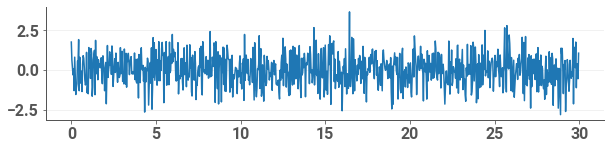

In [21]:
noise = add_gaussian_noise(
    np.zeros(int(30 * metadata.TWOP_SAMPLE_RATE)),
    loc=0,
    scale=1,
)
plot(noise)

## Normalize energy

In [22]:
def energy(signal):
    return np.sum(np.abs(np.fft.rfft(signal))**2)

In [23]:
def _set_energy(signal, target):
    spectrum = np.fft.rfft(signal)
    current_energy = np.sum(np.abs(spectrum)**2)
    ratio = target / current_energy
    spectrum = spectrum * np.sqrt(ratio)
    signal = np.fft.irfft(spectrum)
    assert np.allclose(target, energy(signal))
    return signal

def set_energy(signal, target):
    if isinstance(signal, pd.Series):
        signal[:] = _set_energy(signal.values, target)
        return signal
    return _set_energy(signal, target)

In [24]:
def normalize_energy(signals):
    target = energy(signals[0])
    return [signals[0]] + [set_energy(signal, target) for signal in signals[1:]]

In [25]:
patterns = {
    "irregular": forward_model(irregular_bursts).values,
    "periodic": forward_model(regular_bursts).values,
}
patterns["noise"] = noise + 2*patterns["irregular"].mean()

patterns = dict(zip(patterns.keys(), normalize_energy(list(patterns.values()))))

## Plot signals

In [26]:
order = [
    "periodic",
    "irregular",
    "noise",
]

PosixPath('figures/fig_2-1/signals.svg')

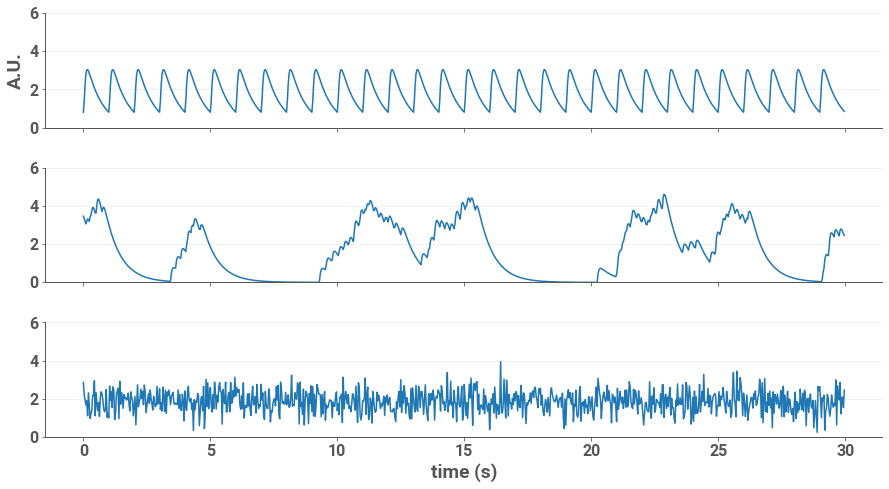

In [27]:
fs = metadata.TWOP_SAMPLE_RATE

fig, axes = plt.subplots(3, 1, figsize=(15, 3 * 2.5), sharex=True, sharey=True)

for signal, ax in zip(order, axes):
    plot(patterns[signal], fs=fs, ax=ax, fig=fig)

axes[0].set_ylim((0, 6))
axes[0].set_ylabel("A.U.")
axes[-1].set_xlabel('time (s)')

fig.subplots_adjust(hspace=0.35)
analysis.savefig(fig, OUTPUT_DIR / "signals")

## Plot differentiation

In [28]:
df = pd.DataFrame(
    [
        {
            "name": name,
            "energy": energy(pattern),
            "differentiation": spectral_differentiation_whole_stimulus(
                pattern.reshape(-1, 1),
                1.0,
                "euclidean",
                metadata.TWOP_SAMPLE_RATE,
                False,
            ),
        }
        for name, pattern in patterns.items()
    ]
)

df["differentiation"] = df["differentiation"].round(10)
df["log(differentiation)"] = np.log10(df["differentiation"])

df

/home/wmayner/miniconda3/envs/openscope-differentiation-test3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,name,energy,differentiation,log(differentiation)
0,irregular,2.933401e+06,4429.196021,3.646325
1,periodic,2.933401e+06,0.000000,-inf
2,noise,2.933401e+06,317.559821,2.501826


PosixPath('figures/fig_2-1/differentiation.svg')

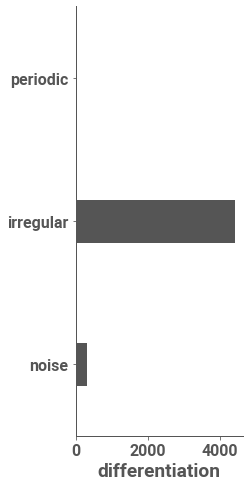

In [29]:
fig = plt.figure(figsize=(3, 7.6))
ax = sb.barplot(
    data=df,
    y="name",
    x="differentiation",
    color="#555",
    order=order,
)
ax.set_ylabel("")

width = 0.3
for bar in ax.patches:
    y = bar.get_y()
    current_width = bar.get_height()
    center = y + current_width / 2
    bar.set_y(center - width / 2)
    bar.set_height(width)
    
analysis.savefig(fig, OUTPUT_DIR / "differentiation")